In [1]:
import platform
import sys
import datetime
import netCDF4
import numpy as np
import importlib
import time
from tqdm import tqdm
if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

import HydroAI.TC_like as hTCL
import HydroAI.Plot as hPlot
import HydroAI.Data as hData
import HydroAI.Grid as hGrid
import matplotlib.pyplot as plt
importlib.reload(hTCL);
importlib.reload(hGrid);
importlib.reload(hPlot);
importlib.reload(hData);

import warnings
warnings.filterwarnings("ignore")
# Define your directory where to save nc files
nc_save_dir = cpuserver_data_FP + '/extracted_nc'

In [2]:
def covariance(X, Y):
    """
    Calculate the covariance between two arrays X and Y, ignoring NaN values, in a vectorized manner.
    Assumes X and Y have the shape (lat, lon, time).
    """
    # Calculate means along the time axis while ignoring NaNs
    mean_X = np.nanmean(X, axis=2, keepdims=True)
    mean_Y = np.nanmean(Y, axis=2, keepdims=True)

    # Subtract the mean from each variable
    X_centered = X - mean_X
    Y_centered = Y - mean_Y

    # Count the number of valid (non-NaN) observations along the time axis
    n_valid = np.sum(~np.isnan(X) & ~np.isnan(Y), axis=2)

    # Calculate the covariance term while ignoring NaNs and applying Bessel's correction
    covariance = np.nansum(X_centered * Y_centered, axis=2) / (n_valid - 1)

    return covariance

def correlation(X, Y):
    """
    Calculate the correlation coefficient between two arrays X and Y, ignoring NaN values, in a vectorized manner.
    Assumes X and Y have the shape (lat, lon, time).
    """
    # Calculate the variances using the nan_covariance function
    covXX = covariance(X, X)
    covYY = covariance(Y, Y)

    # Calculate the covariance between X and Y
    covXY = covariance(X, Y)

    # Calculate the correlation coefficient
    correlation = covXY / np.sqrt(covXX * covYY)

    return correlation

def cov_corr(X, Y, calc_cov=True, calc_corr=True):
    """
    Calculate the covariance, correlation, or both between two arrays X and Y, ignoring NaN values, in a vectorized manner.
    Assumes X and Y have the shape (lat, lon, time).
    
    Parameters:
    - X, Y: Input arrays with shape (lat, lon, time)
    - calc_cov: Boolean indicating whether to calculate covariance
    - calc_corr: Boolean indicating whether to calculate correlation
    
    Returns:
    - covXY: Covariance matrix (if calc_cov is True)
    - corrXY: Correlation matrix (if calc_corr is True)
    """
    # Initialize return values
    covXY = None
    corrXY = None

    # Calculate means along the time axis while ignoring NaNs
    mean_X = np.nanmean(X, axis=2, keepdims=True)
    mean_Y = np.nanmean(Y, axis=2, keepdims=True)

    # Subtract the mean from each variable
    X_centered = X - mean_X
    Y_centered = Y - mean_Y

    # Count the number of valid (non-NaN) observations along the time axis
    n_valid = np.sum(~np.isnan(X) & ~np.isnan(Y), axis=2)

    # Calculate covariance if requested
    if calc_cov or calc_corr:  # Calculate covariance if needed for either output
        covXY = np.nansum(X_centered * Y_centered, axis=2) / (n_valid - 1)

    # Calculate correlation if requested
    if calc_corr:
        # Calculate the variances
        covXX = np.nansum(X_centered * X_centered, axis=2) / (n_valid - 1)
        covYY = np.nansum(Y_centered * Y_centered, axis=2) / (n_valid - 1)
        
        # Calculate the correlation coefficient
        corrXY = covXY / np.sqrt(covXX * covYY)

    # Return the requested values
    if calc_cov and calc_corr:
        return covXY, corrXY
    elif calc_cov:
        return covXY
    elif calc_corr:
        return corrXY

import numpy as np

def cov_corr_three_old(X, Y, Z, calc_cov=True, calc_corr=True):
    """
    Calculate the covariance, correlation, or both for three arrays X, Y, and Z, ignoring NaN values, in a vectorized manner.
    Assumes X, Y, and Z have the shape (lat, lon, time).
    
    Parameters:
    - X, Y, Z: Input arrays with shape (lat, lon, time)
    - calc_cov: Boolean indicating whether to calculate covariance
    - calc_corr: Boolean indicating whether to calculate correlation
    
    Returns:
    - results: A dictionary containing covariances and correlations (depending on the flags)
    """
    results = {}

    # Calculate means along the time axis while ignoring NaNs
    mean_X = np.nanmean(X, axis=2, keepdims=True)
    mean_Y = np.nanmean(Y, axis=2, keepdims=True)
    mean_Z = np.nanmean(Z, axis=2, keepdims=True)

    # Subtract the mean from each variable
    X_centered = X - mean_X
    Y_centered = Y - mean_Y
    Z_centered = Z - mean_Z

    # Count the number of valid (non-NaN) observations along the time axis
    n_valid_XY = np.sum(~np.isnan(X) & ~np.isnan(Y), axis=2)
    n_valid_YZ = np.sum(~np.isnan(Y) & ~np.isnan(Z), axis=2)
    n_valid_XZ = np.sum(~np.isnan(X) & ~np.isnan(Z), axis=2)

    # Calculate covariances between different variables
    if calc_cov or calc_corr:
        results['covXY'] = np.nansum(X_centered * Y_centered, axis=2) / (n_valid_XY - 1)
        results['covYZ'] = np.nansum(Y_centered * Z_centered, axis=2) / (n_valid_YZ - 1)
        results['covXZ'] = np.nansum(X_centered * Z_centered, axis=2) / (n_valid_XZ - 1)

    # Calculate correlations
    if calc_corr:
        # Calculate variances (covariance of each variable with itself)
        covXX = np.nansum(X_centered * X_centered, axis=2) / (n_valid_XY - 1)
        covYY = np.nansum(Y_centered * Y_centered, axis=2) / (n_valid_XY - 1)
        covZZ = np.nansum(Z_centered * Z_centered, axis=2) / (n_valid_YZ - 1)
        # Store variances in the results dictionary
        results['covXX'] = covXX
        results['covYY'] = covYY
        results['covZZ'] = covZZ
    
        results['corrXY'] = results['covXY'] / np.sqrt(covXX * covYY)
        results['corrYZ'] = results['covYZ'] / np.sqrt(covYY * covZZ)
        results['corrXZ'] = results['covXZ'] / np.sqrt(covXX * covZZ)

    return results
    
def cov_corr_three(X, Y, Z, calc_cov=True, calc_corr=True):
    results = {}
    X_2d = X.reshape(-1, X.shape[2])
    Y_2d = Y.reshape(-1, Y.shape[2])
    Z_2d = Z.reshape(-1, Z.shape[2])

    valid_mask = ~np.isnan(X_2d).all(axis=1) & ~np.isnan(Y_2d).all(axis=1) & ~np.isnan(Z_2d).all(axis=1)
    X_valid = X_2d[valid_mask]
    Y_valid = Y_2d[valid_mask]
    Z_valid = Z_2d[valid_mask]

    mean_X = np.nanmean(X_valid, axis=1, keepdims=True)
    mean_Y = np.nanmean(Y_valid, axis=1, keepdims=True)
    mean_Z = np.nanmean(Z_valid, axis=1, keepdims=True)

    X_centered = X_valid - mean_X
    Y_centered = Y_valid - mean_Y
    Z_centered = Z_valid - mean_Z

    n_valid_XY = np.sum(~np.isnan(X_valid) & ~np.isnan(Y_valid), axis=1)
    n_valid_YZ = np.sum(~np.isnan(Y_valid) & ~np.isnan(Z_valid), axis=1)
    n_valid_XZ = np.sum(~np.isnan(X_valid) & ~np.isnan(Z_valid), axis=1)

    original_shape = (X.shape[0], X.shape[1])

    if calc_cov:
        covXY = np.nansum(X_centered * Y_centered, axis=1) / (n_valid_XY - 1)
        covYZ = np.nansum(Y_centered * Z_centered, axis=1) / (n_valid_YZ - 1)
        covXZ = np.nansum(X_centered * Z_centered, axis=1) / (n_valid_XZ - 1)
        
        results['covXY'] = np.full(original_shape, np.nan)
        results['covYZ'] = np.full(original_shape, np.nan)
        results['covXZ'] = np.full(original_shape, np.nan)
        
        results['covXY'][valid_mask.reshape(original_shape)] = covXY
        results['covYZ'][valid_mask.reshape(original_shape)] = covYZ
        results['covXZ'][valid_mask.reshape(original_shape)] = covXZ

    if calc_corr:
        covXX = np.nansum(X_centered * X_centered, axis=1) / (n_valid_XY - 1)
        covYY = np.nansum(Y_centered * Y_centered, axis=1) / (n_valid_XY - 1)
        covZZ = np.nansum(Z_centered * Z_centered, axis=1) / (n_valid_YZ - 1)
    
        corrXY = covXY / np.sqrt(covXX * covYY)
        corrYZ = covYZ / np.sqrt(covYY * covZZ)
        corrXZ = covXZ / np.sqrt(covXX * covZZ)
        
        results['covXX'] = np.full(original_shape, np.nan)
        results['covYY'] = np.full(original_shape, np.nan)
        results['covZZ'] = np.full(original_shape, np.nan)
        results['corrXY'] = np.full(original_shape, np.nan)
        results['corrYZ'] = np.full(original_shape, np.nan)
        results['corrXZ'] = np.full(original_shape, np.nan)
        
        results['covXX'][valid_mask.reshape(original_shape)] = covXX
        results['covYY'][valid_mask.reshape(original_shape)] = covYY
        results['covZZ'][valid_mask.reshape(original_shape)] = covZZ
        results['corrXY'][valid_mask.reshape(original_shape)] = corrXY
        results['corrYZ'][valid_mask.reshape(original_shape)] = corrYZ
        results['corrXZ'][valid_mask.reshape(original_shape)] = corrXZ

    return results

In [3]:
# Set dimensions
lat_size = 2
lon_size = 2
time_size = 100

# Generate random data
X = np.random.random((lat_size, lon_size, time_size))
Y = np.random.random((lat_size, lon_size, time_size))
Z = np.random.random((lat_size, lon_size, time_size))

# Function to add NaN values randomly
def add_random_nans(data, nod_th):
    nan_mask = np.random.rand(*data.shape) < (nod_th / 100)
    data[nan_mask] = np.nan
    return data

# Apply the function to insert NaNs
nan_per = 5  # Set 5% of data points to NaN
X = add_random_nans(X, nan_per)
Y = add_random_nans(Y, nan_per)
Z = add_random_nans(Z, nan_per)

In [4]:
# 1. calculation for the originial data
# Calculate covariance & correlation

combined_nan_mask = np.isnan(X) | np.isnan(Y) | np.isnan(Z)
X[combined_nan_mask] = np.nan
Y[combined_nan_mask] = np.nan
Z[combined_nan_mask] = np.nan

cov_corr_results = cov_corr_three(X, Y, Z)
covXY = cov_corr_results.get('covXY')
covXZ = cov_corr_results.get('covXZ')
covYZ = cov_corr_results.get('covYZ')

corrXY = cov_corr_results.get('corrXY')
corrXZ = cov_corr_results.get('corrXZ')
corrYZ = cov_corr_results.get('corrYZ')

# compare the results with previous numpy code
print('****')
print(corrXY[1,1], np.corrcoef(X[1,1,:], Y[1,1,:])[0,1])
print(covXY[1,1], np.cov(X[1,1,:], Y[1,1,:])[0,1])

****
0.021383477058119094 nan
0.00169945839624715 nan


In [5]:
# 2. Vectorized TC calculation
# Scale the data
c1 = 1
c2 = np.nansum(X*Z, axis=2) / np.nansum(Y*Z, axis=2)
c3 = np.nansum(X*Y, axis=2) / np.nansum(Z*Y, axis=2)

Xs = c1 * X
Ys = np.expand_dims(c2, axis=2) * Y
Zs = np.expand_dims(c3, axis=2) * Z
#X=[]; Y=[]; Z=[];

# Calculate covariance with scaled Xs, Ys, and Zs
cov_corr_results_s = cov_corr_three(Xs, Ys, Zs)

covXXs = cov_corr_results_s.get('covXX')
covYYs = cov_corr_results_s.get('covYY')
covZZs = cov_corr_results_s.get('covZZ')
covXYs = cov_corr_results_s.get('covXY')
covXZs = cov_corr_results_s.get('covXZ')
covYZs = cov_corr_results_s.get('covYZ')

# Calculate correlation with scaled Xs, Ys, and Zs
corrXYs = cov_corr_results_s.get('corrXYs')
corrXZs = cov_corr_results_s.get('corrXZs')
corrYZs = cov_corr_results_s.get('corrYZs')

var_Xserr = covXXs - covXYs*covXZs/covYZs
var_Yserr = covYYs - covXYs*covYZs/covXZs
var_Zserr = covZZs - covXZs*covYZs/covXYs

# Calcuate TC numbers
SNR_Xs =  (covXYs * covXZs / covYZs) / var_Xserr
SNR_Ys =  (covXYs * covYZs / covXZs) / var_Yserr
SNR_Zs =  (covXZs * covYZs / covXYs) / var_Zserr

R_XYs = 1 / ((1 + 1/SNR_Xs) * (1 + 1/SNR_Ys)) ** 0.5
R_XZs = 1 / ((1 + 1/SNR_Xs) * (1 + 1/SNR_Zs)) ** 0.5
R_YZs = 1 / ((1 + 1/SNR_Ys) * (1 + 1/SNR_Zs)) ** 0.5

fMSE_Xs = 1 / (1 + SNR_Xs)
fMSE_Ys = 1 / (1 + SNR_Ys)
fMSE_Zs = 1 / (1 + SNR_Zs)

R_XXs = 1 / (1 + 1/SNR_Xs)
R_YYs = 1 / (1 + 1/SNR_Ys)
R_ZZs = 1 / (1 + 1/SNR_Zs)

SNRdb_Xs = 10 * np.log10(SNR_Xs)
SNRdb_Ys = 10 * np.log10(SNR_Ys)
SNRdb_Zs = 10 * np.log10(SNR_Zs)

VAR_err = {'x': var_Xserr, 'y': var_Yserr, 'z': var_Zserr}
SNR = {'x': SNR_Xs, 'y': SNR_Ys, 'z': SNR_Zs}
SNRdb = {'x': SNRdb_Xs, 'y': SNRdb_Ys, 'z': SNRdb_Zs}
R = {'x': R_XXs, 'y': R_YYs, 'z': R_ZZs}
fMSE = {'x': fMSE_Xs, 'y': fMSE_Ys, 'z': fMSE_Zs}

In [8]:
# 3. set the flags
# flag on non-scaled data
corr_th = 0
nod_th = 100
condition_corr = (corrXY < corr_th) | (corrXZ < corr_th) | (corrYZ < corr_th) #flag 1

# falg on scaled data
condition_n_valid = np.sum(~np.isnan(Xs) & ~np.isnan(Ys) & ~np.isnan(Zs), axis=2) < nod_th #flag 2
condition_fMSE = (fMSE_Xs < 0) | (fMSE_Ys < 0) | (fMSE_Zs < 0) | (fMSE_Xs > 1) | (fMSE_Ys > 1) | (fMSE_Zs > 1) #flag 3
condition_negative_vars_err  = (var_Xserr < 0) | (var_Yserr < 0) | (var_Zserr < 0) #flag 4

flags = {'condition_corr': condition_corr, 
        'condition_n_valid': condition_n_valid,
        'condition_fMSE': condition_fMSE,
        'condition_negative_vars_err': condition_negative_vars_err}

In [9]:
# 4. Create the final function
def TCA_vec(X, Y, Z, nod_th=30, corr_th=0):

    # 0. check the NaN and fill with NaN if any of X,Y, and Z value is nan.
    combined_nan_mask = np.isnan(X) | np.isnan(Y) | np.isnan(Z)
    X[combined_nan_mask] = np.nan
    Y[combined_nan_mask] = np.nan
    Z[combined_nan_mask] = np.nan
    
    # 1. calculation for the originial data
    # Calculate covariance
    cov_corr_results = cov_corr_three(X, Y, Z)
    covXY = cov_corr_results.get('covXY')
    covXZ = cov_corr_results.get('covXZ')
    covYZ = cov_corr_results.get('covYZ')
    
    corrXY = cov_corr_results.get('corrXY')
    corrXZ = cov_corr_results.get('corrXZ')
    corrYZ = cov_corr_results.get('corrYZ')
    
    # 2. Vectorized TC calculation
    # Scale the data
    c1 = 1
    c2 = np.nansum(X*Z, axis=2) / np.nansum(Y*Z, axis=2)
    c3 = np.nansum(X*Y, axis=2) / np.nansum(Z*Y, axis=2)
    
    Xs = c1 * X
    Ys = np.expand_dims(c2, axis=2) * Y
    Zs = np.expand_dims(c3, axis=2) * Z
    X=[]; Y=[]; Z=[];
    
    # Calculate covariance with scaled Xs, Ys, and Zs
    cov_corr_results_s = cov_corr_three(Xs, Ys, Zs)
    
    covXXs = cov_corr_results_s.get('covXX')
    covYYs = cov_corr_results_s.get('covYY')
    covZZs = cov_corr_results_s.get('covZZ')
    covXYs = cov_corr_results_s.get('covXY')
    covXZs = cov_corr_results_s.get('covXZ')
    covYZs = cov_corr_results_s.get('covYZ')
    
    # Calculate correlation with scaled Xs, Ys, and Zs
    corrXYs = cov_corr_results_s.get('corrXYs')
    corrXZs = cov_corr_results_s.get('corrXZs')
    corrYZs = cov_corr_results_s.get('corrYZs')
    
    var_Xserr = covXXs - covXYs*covXZs/covYZs
    var_Yserr = covYYs - covXYs*covYZs/covXZs
    var_Zserr = covZZs - covXZs*covYZs/covXYs
    
    # Calcuate TC numbers
    SNR_Xs =  (covXYs * covXZs / covYZs) / var_Xserr
    SNR_Ys =  (covXYs * covYZs / covXZs) / var_Yserr
    SNR_Zs =  (covXZs * covYZs / covXYs) / var_Zserr
    
    R_XYs = 1 / ((1 + 1/SNR_Xs) * (1 + 1/SNR_Ys)) ** 0.5
    R_XZs = 1 / ((1 + 1/SNR_Xs) * (1 + 1/SNR_Zs)) ** 0.5
    R_YZs = 1 / ((1 + 1/SNR_Ys) * (1 + 1/SNR_Zs)) ** 0.5
    
    fMSE_Xs = 1 / (1 + SNR_Xs)
    fMSE_Ys = 1 / (1 + SNR_Ys)
    fMSE_Zs = 1 / (1 + SNR_Zs)
    
    R_XXs = 1 / (1 + 1/SNR_Xs)
    R_YYs = 1 / (1 + 1/SNR_Ys)
    R_ZZs = 1 / (1 + 1/SNR_Zs)
    
    SNRdb_Xs = 10 * np.log10(SNR_Xs)
    SNRdb_Ys = 10 * np.log10(SNR_Ys)
    SNRdb_Zs = 10 * np.log10(SNR_Zs)
    
    VAR_err = {'x': var_Xserr, 'y': var_Yserr, 'z': var_Zserr}
    SNR = {'x': SNR_Xs, 'y': SNR_Ys, 'z': SNR_Zs}
    SNRdb = {'x': SNRdb_Xs, 'y': SNRdb_Ys, 'z': SNRdb_Zs}
    R = {'x': R_XXs, 'y': R_YYs, 'z': R_ZZs}
    fMSE = {'x': fMSE_Xs, 'y': fMSE_Ys, 'z': fMSE_Zs}
    
    # 3. set the flags
    # flag on non-scaled data
    condition_corr = (corrXY < corr_th) | (corrXZ < corr_th) | (corrYZ < corr_th) #flag 1
    
    # falg on scaled data
    condition_n_valid = np.sum(~np.isnan(Xs) & ~np.isnan(Ys) & ~np.isnan(Zs), axis=2) < nod_th #flag 2
    condition_fMSE = (fMSE_Xs < 0) | (fMSE_Ys < 0) | (fMSE_Zs < 0) | (fMSE_Xs > 1) | (fMSE_Ys > 1) | (fMSE_Zs > 1) #flag 3
    condition_negative_vars_err  = (var_Xserr < 0) | (var_Yserr < 0) | (var_Zserr < 0) #flag 4
    
    flags = {'condition_corr': condition_corr, 
            'condition_n_valid': condition_n_valid,
            'condition_fMSE': condition_fMSE,
            'condition_negative_vars_err': condition_negative_vars_err}

    return VAR_err, SNR, SNRdb, R, fMSE, flags

In [10]:
# 5. Compare with the previous TCA lib
_, _, _, _, fMSE_vec, flags = TCA_vec(X, Y, Z, nod_th=20, corr_th = 0)
_, _, _, _, fMSE_old = hTCL.TCA(X, Y, Z, nod_th=20, corr_th=0)
print(fMSE_vec)
print(fMSE_old)

{'x': array([[1.00789512, 0.92260995],
       [0.88346802, 1.00819128]]), 'y': array([[1.0004752 , 0.58726923],
       [0.90516515, 1.05582195]]), 'z': array([[4.05810858, 0.99815668],
       [0.93027734, 1.23129557]])}
{'x': array([[nan, nan],
       [nan, nan]]), 'y': array([[nan, nan],
       [nan, nan]]), 'z': array([[nan, nan],
       [nan, nan]])}


In [11]:
# 6. operational comparison
# 6-1. Comparing vectorized vs non-vectorize code for large in time-scale data
lat_size = 720
lon_size = 1440
time_size = 365

# Generate random data
SMAP_sim = np.random.random((lat_size, lon_size, time_size))
ASCAT_sim = np.random.random((lat_size, lon_size, time_size))
GLDAS_sim = np.random.random((lat_size, lon_size, time_size))

nod_th = 100
corr_th = 0

tic = time.time()
_, _, _, _, fMSE_vec, flags = TCA_vec(SMAP_sim, ASCAT_sim, GLDAS_sim, nod_th=nod_th, corr_th = 0)
toc = time.time()
print('Vectorized code took:', toc - tic, 'sec')

tic = time.time()
_, _, _, _, fMSE_old = hTCL.TCA(SMAP_sim, ASCAT_sim, GLDAS_sim, nod_th=nod_th, corr_th=0)
toc = time.time()
print('Non-vectorized code took:', toc - tic, 'sec')

Vectorized code took: 84.46494221687317 sec
Non-vectorized code took: 159.66005086898804 sec


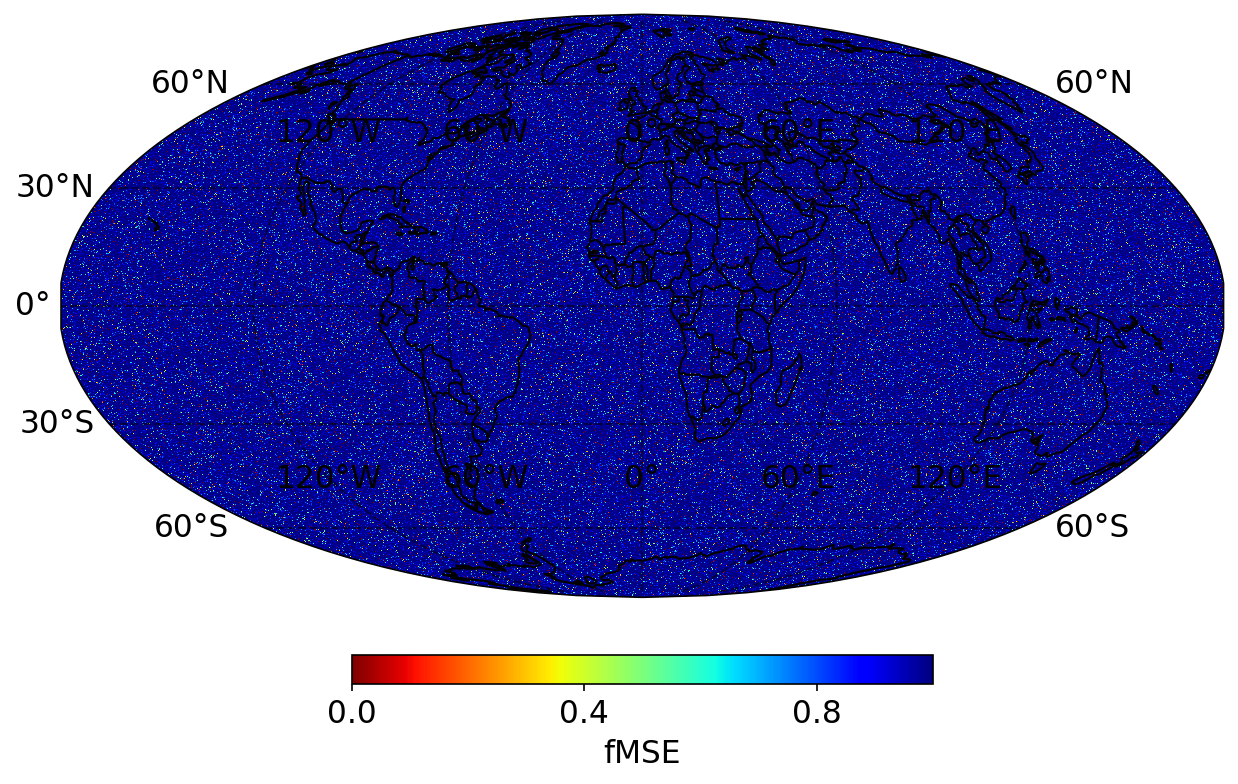

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [12]:
lon, lat = hGrid.generate_lon_lat_eqdgrid(0.25)
hPlot.plot_map(lon, lat, fMSE_vec['x'], 0, 1, plot_title='fMSE', label_title='fMSE', cmap='jet_r', projection='Mollweide')

In [13]:
# 6-2. Comparing vectorized vs non-vectorize code for large in number of operations
lat_size = 100
lon_size = 100
time_size = 91

# Generate random data
SMAP_sim = np.random.random((lat_size, lon_size, time_size))
ASCAT_sim = np.random.random((lat_size, lon_size, time_size))
GLDAS_sim = np.random.random((lat_size, lon_size, time_size))

nod_th = 20
corr_th = 0

tic = time.time()
for i in tqdm(range(100)):
    _, _, _, _, t_fMSE_vec, _ = TCA_vec(SMAP_sim, ASCAT_sim, GLDAS_sim, nod_th=nod_th, corr_th = 0)
toc = time.time()
print('Vectorized code took:', toc - tic, 'sec')

tic = time.time()
for i in tqdm(range(100)):
    _, _, _, _, t_fMSE_old = hTCL.TCA(SMAP_sim, ASCAT_sim, GLDAS_sim, nod_th=nod_th, corr_th=0)
toc = time.time()
print('Non-vectorized code took:', toc - tic, 'sec')

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 19.98it/s]


Vectorized code took: 5.0884690284729 sec


100%|█████████████████████████████████████████| 100/100 [02:07<00:00,  1.27s/it]

Non-vectorized code took: 127.4599461555481 sec


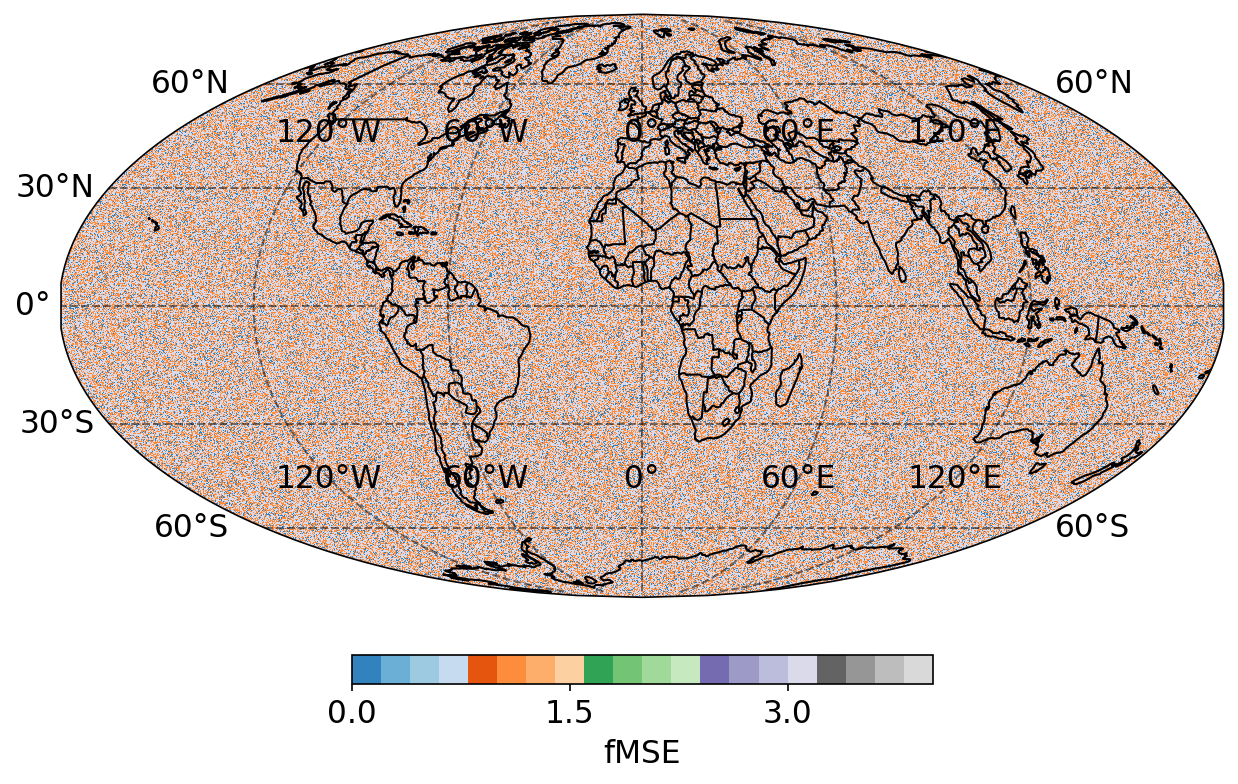

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [14]:
# 6-3. Mapping fMSE_vec flags
flag_map = np.zeros((720,1440))
condition_corr = flags['condition_corr']
condition_n_valid = flags['condition_n_valid']
condition_fMSE = flags['condition_fMSE']
condition_negative_vars_err = flags['condition_negative_vars_err']
flag_map[condition_corr] = 1
flag_map[condition_n_valid] = 2 
flag_map[condition_fMSE] = 3
flag_map[condition_negative_vars_err] = 4
hPlot.plot_map(lon, lat, flag_map, 0, 4, plot_title='fMSE', label_title='fMSE', cmap='tab20c', projection='Mollweide')

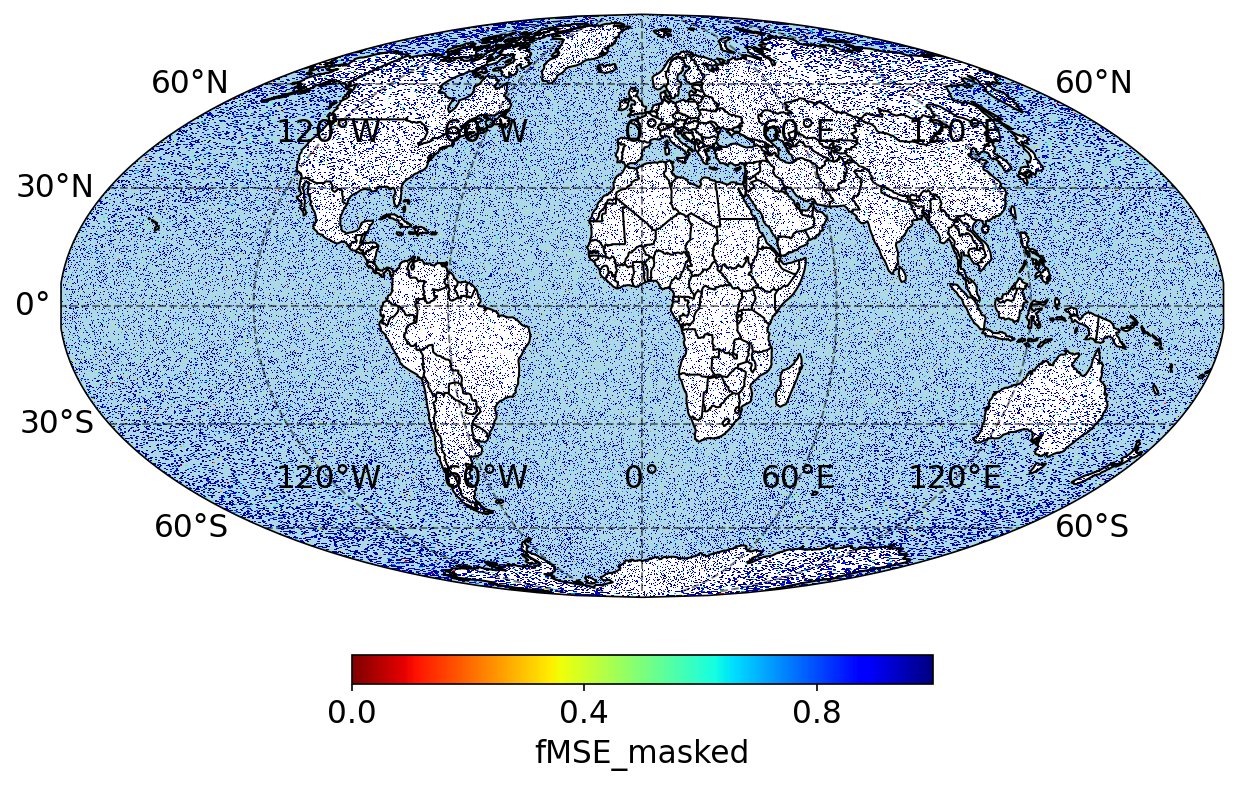

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [15]:
# 6-4. Masking fMSE_vec data based on flag
fMSE_vec_masked = fMSE_vec['x'].copy()
fMSE_vec_masked[flag_map != 0] = np.nan
hPlot.plot_map(lon, lat, fMSE_vec_masked, 0, 1, plot_title='fMSE_masked', label_title='fMSE_masked', cmap='jet_r', projection='Mollweide')

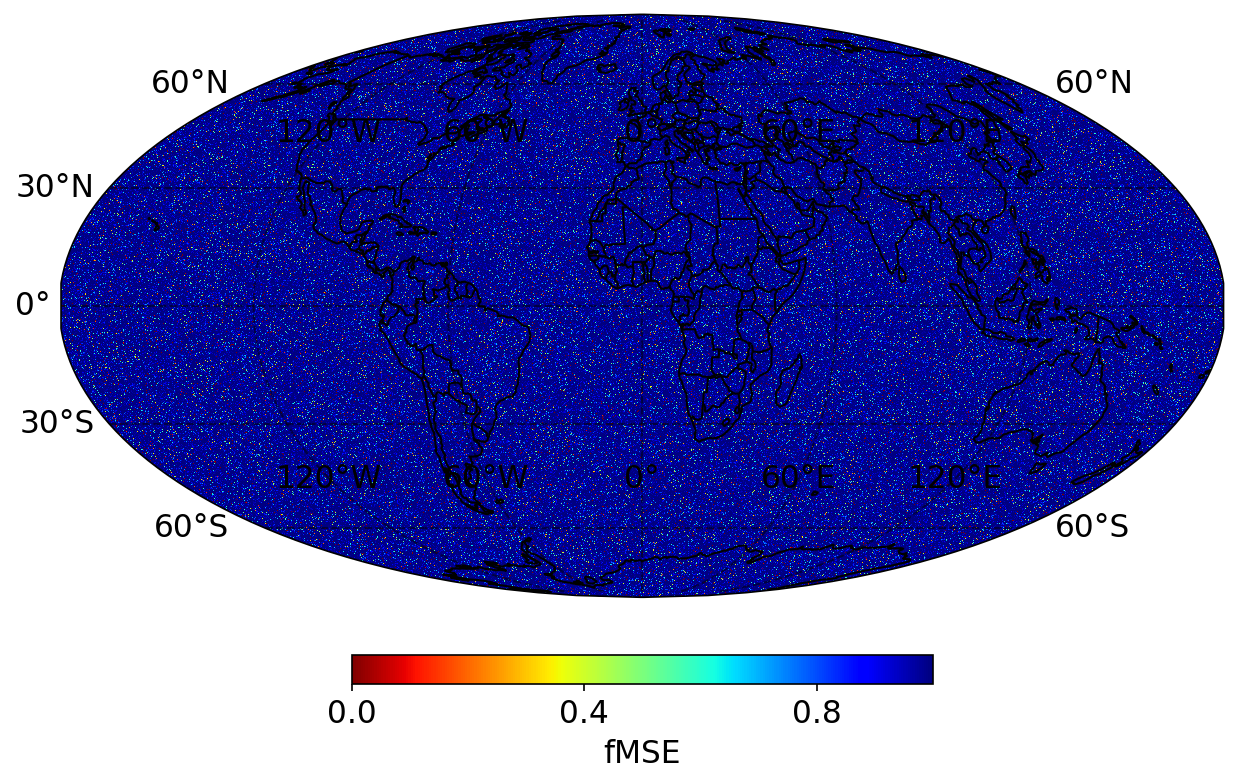

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [16]:
# 7. For the real data set and library application 
lat_size = 720
lon_size = 1440
time_size = 365

# Generate random data
SMAP = np.random.random((lat_size, lon_size, time_size))
ASCAT = np.random.random((lat_size, lon_size, time_size))
GLDAS = np.random.random((lat_size, lon_size, time_size))

_, _, _, _, fMSE_vec, flags = hTCL.TCA_vec(SMAP, ASCAT, GLDAS)
hPlot.plot_map(lon, lat, fMSE_vec['x'], 0, 1, plot_title='fMSE', label_title='fMSE', cmap='jet_r', projection='Mollweide')